## Initialisation

In [224]:
import copy
import random
import time
import pprint

from matplotlib import pyplot as plt
from pymongo import MongoClient
import numpy as np


# Init
mongo = MongoClient('localhost', 27017)
db = mongo['citeos']
collection_villes = db['villes']
collection_routes = db['routes']
collection_clients = db['clients']

num_clients_FR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'frais'}}])))
num_clients_PA = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'particulier'}}])))
num_clients_PR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'prisonnier'}}])))

num_clients_FR.append(0)
num_clients_PA.append(0)
num_clients_PR.append(0)

roads_FR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_FR}, 'id_ville_2': {'$in': num_clients_FR}})))
roads_PA = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PA}, 'id_ville_2': {'$in': num_clients_PA}})))
roads_PR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PR}, 'id_ville_2': {'$in': num_clients_PR}})))

num_clients_FR.remove(0)
num_clients_PA.remove(0)
num_clients_PR.remove(0)

## Fonction Voisin

In [2]:
def neighborhood(circuit):
    """
    Cette fonction est un generateur de tous les voisins valides d'une solution
    """
    for i in range (1, len(circuit) - 2):
        neighbor_circuit = circuit.copy()
        neighbor_circuit[i], neighbor_circuit[i + 1] = neighbor_circuit[i + 1], neighbor_circuit[i]
        yield neighbor_circuit

## Fonction Recuperation Routes

In [3]:
def import_roads(cities, roads):
    cities.append(0)
    return np.array([road for road in roads if road['id_ville_1'] in cities and road['id_ville_2'] in cities])


## Fonction Score

In [180]:
def search(node,roads, circuit):
    for item in roads:
        if (item["id_ville_1"] == circuit[node] and item["id_ville_2"] == circuit[node + 1]) or (item["id_ville_1"] == circuit[node + 1] and item["id_ville_2"] == circuit[node]):
            return item

def circuit_score_test(circuit, roads):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        #road = [item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i])][0]
        #road = next(item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]))
        #road = list(collection_routes.find({'id_ville_1': {'$in': [i, i + 1]}, 'id_ville_2': {'$in': [i, i + 1]}}))[0]
        #road = next(filter(lambda item: (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]), roads))#
        road = search(i, roads, circuit)
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score

def circuit_score(circuit, roads, header):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        #road = [item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i])][0]
        #road = next(filter(lambda item: (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]), roads))
        name = f"route {circuit[i]}/{circuit[i + 1]}" if circuit[i] > circuit[i + 1] else f"route {circuit[i + 1]}/{circuit[i]}"
        road = roads[header[name]]
        #road = search(i, roads, circuit)
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score




test_circuit = [2,12,13,27,31,36,41,56,73,77]
print(num_clients_PA)
a = copy.deepcopy(num_clients_PA)
r = import_roads(a, roads_PA)

start = time.perf_counter()


dic = {}
for idx, b in enumerate(r):
    dic[b["route"]] = idx


print(time.perf_counter() - start)

start = time.perf_counter()
for _ in range(0, 5):
    f = circuit_score(a, r, dic)

print(time.perf_counter() - start)

start = time.perf_counter()

for _ in range(0, 5):
    e = circuit_score_test(a, r)
print(time.perf_counter() - start)

print(f)
print(e)

[2, 12, 13, 27, 31, 36, 41, 56, 73, 77, 81, 83, 85, 89, 92, 110, 111, 122, 126, 133, 136, 138, 141, 145, 151, 153, 154, 163, 168, 175, 180, 183, 198, 199, 217, 218, 219, 225, 228, 232, 237, 238, 240, 246, 260, 274, 282, 283, 288, 291, 293, 296, 299, 300, 302, 304, 318, 321, 323, 328, 329, 330, 335, 338, 339, 341, 350, 353, 354, 361, 362, 375, 386, 389, 390, 392, 401, 403, 405, 407, 418, 422, 429, 432, 433, 434, 444, 448, 450, 451, 455, 467, 470, 482, 496, 517, 519, 531, 534, 539, 545, 546, 548, 552, 566, 576, 578, 579, 582, 589, 594, 595, 601, 602, 604, 610, 615, 618, 622, 624, 626, 641, 646, 648, 649, 660, 661, 662, 663, 687, 689, 694, 716, 717, 719, 724, 727, 742, 744, 757, 765, 766, 768, 779, 783, 785, 789, 793, 797, 811, 816, 819, 820, 823, 831, 844, 849, 850, 853, 860, 861, 864, 868, 869, 874, 883, 891, 892, 902, 912, 913, 927, 937, 940, 941, 944, 954, 959, 960, 964, 967, 969, 973, 978, 979, 989, 991]
0.007042299999739043
0.0007089999999152496
1.9260204000001977
58208
58208


## Recherche Tabou

In [186]:
def tabu_search(initial_circuit, tabu_size, max_iteration, actual_roads, actual_roads_header):
    iteration = 1
    tabu_list = list()
    actual_circuit = initial_circuit.copy()

    best_actual_circuit = initial_circuit.copy()
    best_total_circuit = initial_circuit.copy()
    best_total_value = circuit_score(best_total_circuit, actual_roads, actual_roads_header)

    best_total_list = list()
    best_actual_list = list()

    while iteration <= max_iteration:
        iteration += 1
        best_actual_value = -1

        # on parcourt les voisins de la solution courante
        for neighbor in neighborhood(actual_circuit):
            if neighbor not in tabu_list : score = circuit_score(neighbor, actual_roads, actual_roads_header)
            else: continue
            if score <= best_actual_value or best_actual_value == -1:
                best_actual_value = score
                best_actual_circuit = neighbor.copy()

        # on met a jour la meilleur solution rencontree depuis le debut
        if best_actual_value < best_total_value:
            best_total_circuit = best_actual_circuit.copy()
            best_total_value = best_actual_value

        best_total_list.append(best_total_value)
        best_actual_list.append(best_actual_value)

        actual_circuit = best_actual_circuit.copy()

        if len(tabu_list) >= tabu_size: tabu_list.pop(0)
        tabu_list.append(actual_circuit.copy())

    return best_total_circuit, best_total_list, best_actual_list

## Multi-start

In [252]:
def tabu_multi_start(number, iteration, shuffled, actual_roads, actual_roads_header, tabu_size):
    best_local_score = -1
    best_local_circuit = []
    for i in range(0, number):
        shuffled_circuit = shuffled.copy()
        shuffled_circuit.append(0)
        shuffled_circuit.insert(0, 0)
        bc, bt, ba= tabu_search(shuffled_circuit, tabu_size, iteration, actual_roads, actual_roads_header)
        actual_score = circuit_score(bc, actual_roads, actual_roads_header)

        if best_local_score == -1 or actual_score < best_local_score:
            best_local_score = actual_score
            best_local_circuit = bc

        random.shuffle(shuffled)
    return [best_local_circuit, best_local_score]

## Graphe vers circuits

In [258]:
def create_circuits(clients_list, roads_list, k):

    k = k - len(clients_list)

    total_of_clients = sum(len(client_list) for client_list in clients_list)
    number_of_clients = [len(client_list) for client_list in clients_list]
    trucks_for_lists = [int(k * percentage) for percentage in [len(client_list) / total_of_clients for client_list in clients_list]]

    while sum(trucks_for_lists) != k: trucks_for_lists[random.randint(0, len(trucks_for_lists) - 1)] += 1

    print(number_of_clients)

    origins = [0] * len(clients_list)
    clients_per_k = [noc // tfl for noc, tfl in zip(number_of_clients, trucks_for_lists)]
    difference = [noc % (cpk * tfl) for noc, cpk, tfl in zip(number_of_clients, clients_per_k, trucks_for_lists)]
    best_circuits = [[] for _ in range (len(clients_list))]

    for idx, client_list in enumerate(clients_list):
        passed = [origins[idx],]
        actual_node = random.choice(client_list)
        for truck in range(0, trucks_for_lists[idx]):

            truck_circuit = [actual_node,]
            passed.append(actual_node)

            while len(truck_circuit) != clients_per_k[idx]:
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])

            if difference[idx] > 0:
                difference[idx] -= 1
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])

            if len(truck_circuit) % 6 == 0:
                actual_node = get_closer_node(truck_circuit[0], roads_list[idx], passed)
            else:
                actual_node = get_closer_node(truck_circuit[-1], roads_list[idx], passed)

            if truck == trucks_for_lists[idx] - 1:
                best_circuits[idx].append(truck_circuit[:int(len(truck_circuit) // 1.5)])
                best_circuits[idx].append(truck_circuit[int(len(truck_circuit) // 1.5):])
            else:
                best_circuits[idx].append(truck_circuit)
    return best_circuits



c = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], 30)
tot = 0
totb = 0
print(c)
for i in c:
    totb += len(i)
    for j in i:
        tot += len(j)
print(tot)
print(len(num_clients_FR))
print(totb)

[156, 187, 176]
[[[836, 53, 8, 700, 445, 758, 351, 958, 424, 935, 86, 393, 507, 561, 21, 951, 847, 395, 463, 702], [447, 873, 159, 87, 493, 829, 544, 838, 130, 591, 324, 88, 356, 290, 192, 569, 345, 943, 485, 112], [18, 104, 563, 900, 68, 132, 707, 478, 839, 897, 305, 127, 993, 437, 420, 666, 436, 252, 94, 886], [833, 79, 10, 308, 171, 875, 580, 483, 681, 903, 71, 623, 1, 721, 787, 258, 786, 74, 627, 516], [319, 848, 974, 655, 381, 259, 651, 84, 810, 376, 452, 137, 842, 97, 799, 524, 476, 169, 99], [16, 131, 230, 762, 647, 532, 14, 880, 734, 968, 211, 384, 473, 188, 747, 427, 513, 678, 679], [203, 522, 520, 540, 255, 609, 262, 468, 222, 939, 285, 884, 806, 156, 287, 207, 69, 229, 214], [556, 790, 543, 43, 726, 598, 621, 521, 506, 553, 788, 275], [530, 15, 363, 919, 415, 400, 176]], [[232, 2, 534, 375, 341, 742, 978, 641, 960, 860, 422, 595, 646, 183, 433, 819, 783, 779, 660, 891, 151], [940, 912, 429, 110, 615, 392, 789, 240, 180, 944, 153, 77, 432, 111, 237, 902, 727, 434, 785, 199, 8

In [243]:
test  = [222, 786, 74, 627, 351, 758,6,7, 445, 700, 707, 478, 839, 53, 836, 127, 993, 437, 420, 666, 436, 252]
print(test[: int(len(test) // 1.5)])
print(test[int(len(test) // 1.5):])


[222, 786, 74, 627, 351, 758, 6, 7, 445, 700, 707, 478, 839, 53]
[836, 127, 993, 437, 420, 666, 436, 252]


## Glouton

In [184]:
def get_closer_node(node, roads, ignored):
    min_weight = -1
    next_node = 0
    roads = [r for r in roads if r["id_ville_1"] not in ignored or r["id_ville_2"] not in ignored]
    for road in roads:
        if road['est_oriente']:
            if (road['id_ville_1'] == node) and (min_weight == -1 or min_weight > road['poids_1']):
                min_weight = road['poids_1']
                next_node = road['id_ville_2']
            elif (road['id_ville_2'] == node) and (min_weight == -1 or min_weight > road['poids_2']):
                min_weight = road['poids_2']
                next_node = road['id_ville_1']
        elif (min_weight > road['poids'] or  min_weight == -1) and (road["id_ville_1"] == node or road["id_ville_2"] == node):
            min_weight = road['poids']
            next_node = road['id_ville_1'] if road["id_ville_2"] == node else road['id_ville_2']

    return next_node

## Tests

In [9]:
#circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], k)




[156, 187, 176]
0
[[0, 842, 137, 943, 485, 112, 18, 104, 563, 543, 900, 68, 132, 0], 671]
[[0, 702, 463, 171, 875, 580, 483, 681, 903, 71, 623, 707, 478, 0], 502]
[[0, 393, 935, 86, 447, 873, 159, 87, 493, 424, 958, 97, 0], 354]
[[0, 507, 561, 21, 951, 847, 395, 324, 445, 700, 8, 53, 0], 670]
[[0, 836, 127, 993, 437, 420, 666, 436, 252, 94, 833, 886, 0], 606]
[[0, 255, 540, 520, 522, 203, 308, 211, 968, 319, 10, 79, 0], 618]
[[0, 848, 974, 655, 381, 721, 787, 345, 591, 130, 544, 838, 0], 666]
[[0, 156, 74, 627, 207, 516, 530, 569, 192, 290, 15, 287, 0], 779]
[[0, 762, 758, 351, 69, 229, 521, 305, 532, 647, 556, 214, 0], 519]
[[0, 513, 427, 747, 188, 473, 384, 468, 230, 678, 131, 679, 0], 447]
[[0, 275, 788, 609, 262, 786, 222, 16, 99, 169, 598, 356, 0], 864]
[[0, 810, 259, 799, 829, 553, 452, 376, 524, 476, 84, 651, 0], 823]
[[0, 734, 880, 14, 363, 790, 621, 43, 88, 839, 897, 258, 0], 908]
[[0, 919, 1, 939, 285, 884, 806, 506, 0], 605]
[[0, 415, 400, 726, 176, 0], 1239]
1
[[0, 392, 615

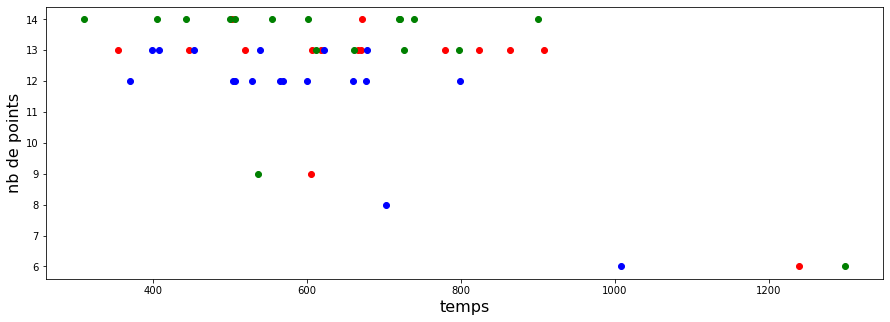

In [259]:
final = []
n = 5
it = 250
k = 50
ts = 80

roads_all = [roads_FR, roads_PA, roads_PR]
circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], roads_all, k)

colors = ['red', 'green', 'blue']

start = time.perf_counter()
plt.figure(figsize=(15,5))
for i, circuits in enumerate(circuits_per_type):
    print(i)
    print("===================================================================================")

    for j, circuit in enumerate(circuits):
        roads_content = import_roads(circuit.copy(), roads_all[i])
        roads_header = {}
        for idx, r in enumerate(roads_content):
            roads_header[r["route"]] = idx

        final.append(tabu_multi_start(n, it, circuit.copy(), roads_content, roads_header, ts))
        print(final[-1])
        plt.xlabel("temps", fontsize=16)
        plt.ylabel("nb de points", fontsize=16)
        plt.scatter(final[-1][1], len(final[-1][0]), color=colors[i],)

print(time.perf_counter() - start)
print(final)

tot = 0

for i in final:
    print(i[0])
    tot += len(i[0]) - 2

print(tot)